<a href="https://colab.research.google.com/github/larissa-rangel/Espectro/blob/main/balanco_hidrico_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Balanço Hídrico por decêndio

Inputs: temperatura, precipitação e radiação

Output: evapotranspiração, déficit e excedente hídricos

In [397]:
from google.colab import drive

drive.mount('/content/drive')
#Importando todas as bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as m
from datetime import datetime, timedelta

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset GEE

In [398]:
temperatura = pd.read_csv('/content/drive/MyDrive/Espectro_Drive/Dados/GEE/temperatura.csv') #carrega os dado do drive
temperatura['Date'] = pd.to_datetime(temperatura['Date'], errors='coerce') #converte a coluna para o tipo datetime64[ns]
temperatura['Mes'] = temperatura['Date'].dt.month # Adicionando uma coluna para o mês
#print(temperatura.info())
#print(temperatura.to_string())

In [399]:
radiacao = pd.read_csv('/content/drive/MyDrive/Espectro_Drive/Dados/GEE/radiacao.csv')
radiacao['Data'] = pd.to_datetime(radiacao['Data'], errors='coerce')
radiacao['Mes'] = radiacao['Data'].dt.month # Adicionando uma coluna para o mês
#print(radiacao.info())
#print(radiacao.to_string())

In [400]:
radiacao

,Data,radiacao_MJ_por_m2,Mes
0,2017-12-29,17.026,12
1,2017-12-30,19.589,12
2,2017-12-31,19.885,12
3,2018-01-01,20.810,1
4,2018-01-02,16.417,1
...,...,...,...
1824,2022-12-27,26.583,12
1825,2022-12-28,19.761,12
1826,2022-12-29,17.828,12
1827,2022-12-30,25.581,12


In [401]:
precipitacao = pd.read_csv('/content/drive/MyDrive/Espectro_Drive/Dados/GEE/precipitacao.csv') #carrega os dado do drive
precipitacao['Data'] = pd.to_datetime(precipitacao['Data'], errors='coerce') #converte a coluna para o tipo datetime64[ns]
precipitacao['Mes'] = precipitacao['Data'].dt.month # Adicionando uma coluna para o mês

#print(precipitacao.info())
#print(precipitacao.to_string())


## ETP - Priestley e Taylor

In [402]:
def Priestley_Taylor(data_inicial,data_final,radiacao,temperatura):

  Rn = radiacao['radiacao_MJ_por_m2'].to_numpy()
  T = temperatura['Tmean'].to_numpy()

  dp_tres = int(np.where(temperatura['Date'] == data_inicial - timedelta(days=3))[0])
  dp = int(np.where(temperatura['Date'] == data_inicial)[0])
  dc = int(np.where(temperatura['Date'] == data_final)[0])

  T = T[dp_tres:dc+1]
  Rn = Rn[dp:dc+1]
  Etp_estimada = np.zeros(len(T)-3)

  #cáculo da ETP por dia
  aux = 0
  for i in range (3,len(T),1):
    #print(i)
    #print(temperatura['Date'][i])
    #print(aux)

    if T[i]>=0.0 and T[i]<=16.0:
      W = 0.407+0.0145*T[i]
      G = 0.38*(T[i]-np.mean(T[i-3:i]))
      Etp_estimada [aux] = 1.26*W*(Rn[aux]-G)/2.45
    elif T[i]>16.0 and T[i]<=32.0:
      W = 0.483+0.01*T[i]
      G = 0.38*(T[i]-np.mean(T[i-3:i]))
      Etp_estimada [aux] = 1.26*W*(Rn[aux]-G)/2.45
    else:
      print("Temperatura fora da faixa")
      Etp_estimada [aux] = -99

    aux +=1

  Etp = pd.concat([pd.DataFrame(pd.date_range(start=data_inicial, end=data_final, inclusive="both"), columns = ['janela_plantio']),
                    pd.DataFrame(Etp_estimada,columns=['Etp_estimada'])], axis=1)
  Etp['janela_plantio'] = pd.to_datetime(Etp['janela_plantio'], errors='coerce')
  Etp['Mes'] = Etp['janela_plantio'].dt.month # Adicionando uma coluna para o mês
  Etp['Ano'] = Etp['janela_plantio'].dt.year# Criando uma nova coluna 'Ano' com o ano correspondente a cada data


  return(Etp)

## Balanço Hídrico

In [403]:
def gerar_coeficientes_cultura_decendio(mes_semeadura, mes):
  kc_base = np.ones(len(mes))
  padrao = np.array([0.33, 0.9, 1.1, 0.66])
  meses = np.arange(mes_semeadura,mes_semeadura+len(padrao),1)


  for i in range(len(padrao)):
    for ii in range(len(mes)):
      if mes[ii] == meses[i]:
        kc_base[ii] = padrao[i]

  return kc_base

In [404]:
def balanco_hidrico(cad,mes_semeadura,num_anos,evapo,precipitacao):
  Etp = evapo['Etp_estimada'].to_numpy()
  P = precipitacao['Precipitacao'].to_numpy()
  #Kc = gerar_coeficientes_cultura(mes_semeadura, num_anos)
  Kc = gerar_coeficientes_cultura_decendio(mes_semeadura, evapo['Mes'].to_numpy())
  Etc = Kc*Etp
  P_Etc = P - Etc

  nac = np.zeros(len(P_Etc)) #negativo acumulado
  arm = np.zeros(len(P_Etc)) #armazenamento corrigido
  alt = np.zeros(len(P_Etc)) #alteração
  #Calcula o armazenamento, o Nac e a alteração
  arm[0] = cad
  for i in range(1,len(P_Etc),1):
    if P_Etc[i] > 0:
      arm[i] = arm[i-1] + P_Etc[i]
      if arm[i] > cad:
        arm[i] = cad
        nac[i] = cad*m.log(arm[i]/cad)
      else:
        nac[i] = cad*m.log(arm[i]/cad)

    if P_Etc[i] < 0:
      nac[i] = nac[i-1] + P_Etc[i]
      arm[i] = cad * m.exp(-1*abs(nac[i]/cad))

    alt[i] = arm[i] - arm[i-1]

  #Calcula a evapo de referência
  Etr = np.zeros(len(P_Etc))
  for i in range(len(P_Etc)):
    if P_Etc[i]<0:
      Etr[i] = P[i] + abs(alt[i])
    else:
      Etr[i] = Etc[i]

  #Calcula o défcit e o excedente hídrico
  DEF = Etc - Etr
  EXC = np.zeros(len(P_Etc))
  for i in range (len(P_Etc)):
    if arm[i] < cad:
      EXC[i] = 0
    elif arm[i] == cad:
      EXC[i] = P_Etc[i] - alt[i]

  frame = pd.concat([pd.DataFrame(evapo['decendio'], columns = ['decendio']),
                    pd.DataFrame(evapo['Mes'], columns = ['Mes']),
                    pd.DataFrame(evapo['Etp_estimada'], columns = ['Etp_estimada']),
                    pd.DataFrame(Kc, columns = ['Kc']),
                    pd.DataFrame(Etc, columns = ['Etc']),
                    pd.DataFrame(P, columns = ['precipitacao']),
                    pd.DataFrame(DEF, columns = ['DEF']),
                    pd.DataFrame(EXC, columns = ['EXC'])],
                    axis=1)
  frame['decendio'] = pd.to_datetime(frame['decendio'], errors='coerce')

  return frame

## Estimação da Evapotranspiração

In [405]:
data_inicial = pd.to_datetime('2018-09-01')  #formato da data YYYY-MMMM-DDDD
data_final = pd.to_datetime('2019-05-31')

Etp_Priestley_Taylor = Priestley_Taylor(data_inicial,data_final,radiacao,temperatura)

In [406]:
Etp_Priestley_Taylor

,janela_plantio,Etp_estimada,Mes,Ano
0,2018-09-01,8.356989,9,2018
1,2018-09-02,4.347364,9,2018
2,2018-09-03,8.424412,9,2018
3,2018-09-04,8.316439,9,2018
4,2018-09-05,9.910286,9,2018
...,...,...,...,...
268,2019-05-27,6.077363,5,2019
269,2019-05-28,5.506594,5,2019
270,2019-05-29,5.916602,5,2019
271,2019-05-30,6.679755,5,2019


## Decêndio

In [407]:
#segmentar o DataFrame para a janela de plantio
P_segmentada = precipitacao.loc[(precipitacao['Data'] >= data_inicial) & (precipitacao['Data'] <= data_final)].drop('Evapotranspiracao', axis=1)

In [408]:
# Agrupando  por decêndios e e calculando a soma da precipitacao
precipitacao_decendio = P_segmentada.groupby(pd.Grouper(key='Data', freq='10D'))['Precipitacao'].sum().reset_index()

# Criando uma nova coluna 'Ano' com o ano correspondente a cada data
precipitacao_decendio['Ano'] = precipitacao_decendio['Data'].dt.year

# Criando uma nova coluna 'Mes' com o ano correspondente a cada data
precipitacao_decendio['Mes'] = precipitacao_decendio['Data'].dt.month

precipitacao_decendio = precipitacao_decendio.rename(columns={'Data': 'decendio'})

precipitacao_decendio = precipitacao_decendio[['decendio', 'Ano', 'Mes', 'Precipitacao']]

#print(precipitacao_decendio)

In [409]:
# Agrupando  por decêndios e e calculando a soma da evapotranspiração
evapotranspiracao_decendio = Etp_Priestley_Taylor.groupby(pd.Grouper(key='janela_plantio', freq='10D'))['Etp_estimada'].sum().reset_index()

# Criando uma nova coluna 'Ano' com o ano correspondente a cada data
evapotranspiracao_decendio['Ano'] = evapotranspiracao_decendio['janela_plantio'].dt.year

# Criando uma nova coluna 'Mes' com o ano correspondente a cada data
evapotranspiracao_decendio['Mes'] = evapotranspiracao_decendio['janela_plantio'].dt.month

evapotranspiracao_decendio = evapotranspiracao_decendio.rename(columns={'janela_plantio': 'decendio'})

# Reorganize as colunas
evapotranspiracao_decendio = evapotranspiracao_decendio[['decendio', 'Ano', 'Mes', 'Etp_estimada']]

#print(evapotranspiracao_decendio)

## Dados com balanceamento hídrico

In [410]:
cad = 65
mes_semeadura = 9
num_anos = 1
tab = balanco_hidrico(cad,mes_semeadura,num_anos,evapotranspiracao_decendio,precipitacao_decendio)

In [411]:
tab

,decendio,Mes,Etp_estimada,Kc,Etc,precipitacao,DEF,EXC
0,2018-09-01,9,91.503610,0.33,30.196191,6.973,23.223191,-23.223191
1,2018-09-11,9,75.782764,0.33,25.008312,97.083,0.000000,72.074688
2,2018-09-21,9,75.900740,0.33,25.047244,83.919,0.000000,58.871756
3,2018-10-01,10,79.163171,0.90,71.246853,76.040,0.000000,4.793147
4,2018-10-11,10,77.044737,0.90,69.340263,81.232,0.000000,11.891737
5,2018-10-21,10,72.840160,0.90,65.556144,108.449,0.000000,42.892856
6,2018-10-31,10,71.924098,0.90,64.731688,43.047,3.246312,0.000000
7,2018-11-10,11,71.450543,1.10,78.595597,98.637,0.000000,1.603027
8,2018-11-20,11,72.494734,1.10,79.744207,67.664,1.056122,0.000000
9,2018-11-30,11,93.708136,1.10,103.078950,24.232,40.917810,0.000000


## Figuras

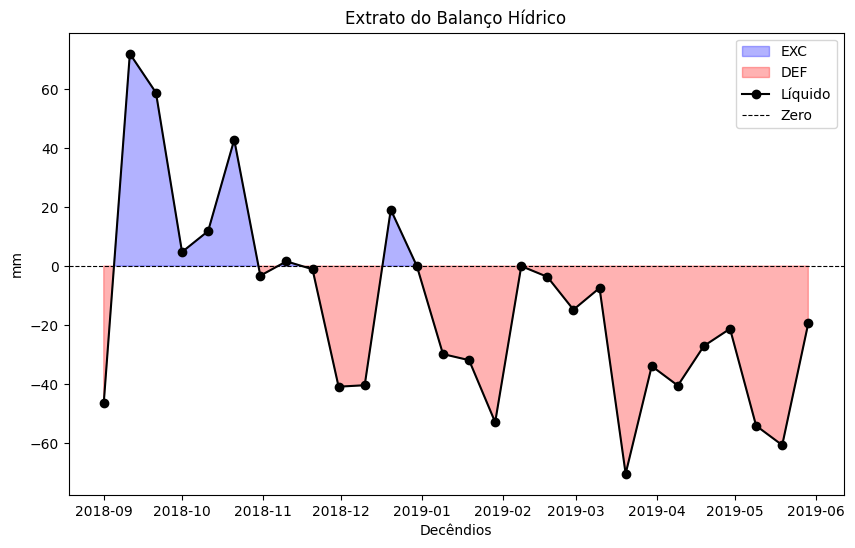

In [412]:
# Dados de exemplo
meses = tab['decendio']
receita = tab['EXC'].to_numpy()
gasto = tab['DEF'].to_numpy()

# Calcular o saldo
saldo = receita - gasto

# Criar o gráfico com área sombreada
plt.figure(figsize=(10, 6))

plt.fill_between(meses, 0, saldo, where=(saldo >= 0), interpolate=True, color='blue', alpha=0.3, label='EXC')
plt.fill_between(meses, 0, saldo, where=(saldo < 0), interpolate=True, color='red', alpha=0.3, label='DEF')

# Linha para o saldo
plt.plot(meses, saldo, label='Líquido', color='black', marker='o')

# Configurações do gráfico
plt.xlabel('Decêndios')
plt.ylabel('mm')
plt.title('Extrato do Balanço Hídrico')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--', label='Zero')
plt.legend(loc='best')

# Exibir o gráfico
plt.show()
